In [40]:
# Dependencies
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# Loading the dataset and splitting it

df = pd.read_csv("../Data/data.csv")

# Drop useless columns
df = df.drop(columns=["id", "Unnamed: 32"], errors="ignore")

# Features (all numeric columns except diagnosis)
X = df.drop(columns=["diagnosis"])

# Target (diagnosis column: M/B -> 0/1)
y = LabelEncoder().fit_transform(df["diagnosis"])

# Split 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Exercise 1 Data preparation
## Q1.1 Load the dataset, inspect feature names and target distribution. Comment on dataset imbalance

In [42]:
# Q1.1 Counting how many samples are malignant or benign

y = df.diagnosis

unique, counts = np.unique(y, return_counts=True)
print(unique, counts, (counts / len(y))*100)

['B' 'M'] [357 212] [62.74165202 37.25834798]


The dataset consists of 30 numeric values of features that describe the characteristics of tumors computed from images of breasts. These include mean values, error estimates and worst-case values, and they have information on the tumor size, shape and texture etc.

The dataset also consists of 569 samples with 30 features each. The target variable is whether the tumor is malignant or benign, where 63% of the dataset is benign and 37% is malignant. This means there is a slight imbalance towards the benign class, which should be considered when evaluating model performance.

## Q1.2 Analyzing all features with and without standardization and plotting them.

                               mean         std         min         max
radius_mean               14.127292    3.524049    6.981000    28.11000
texture_mean              19.289649    4.301036    9.710000    39.28000
perimeter_mean            91.969033   24.298981   43.790000   188.50000
area_mean                654.889104  351.914129  143.500000  2501.00000
smoothness_mean            0.096360    0.014064    0.052630     0.16340
compactness_mean           0.104341    0.052813    0.019380     0.34540
concavity_mean             0.088799    0.079720    0.000000     0.42680
concave points_mean        0.048919    0.038803    0.000000     0.20120
symmetry_mean              0.181162    0.027414    0.106000     0.30400
fractal_dimension_mean     0.062798    0.007060    0.049960     0.09744
radius_se                  0.405172    0.277313    0.111500     2.87300
texture_se                 1.216853    0.551648    0.360200     4.88500
perimeter_se               2.866059    2.021855    0.757000    2

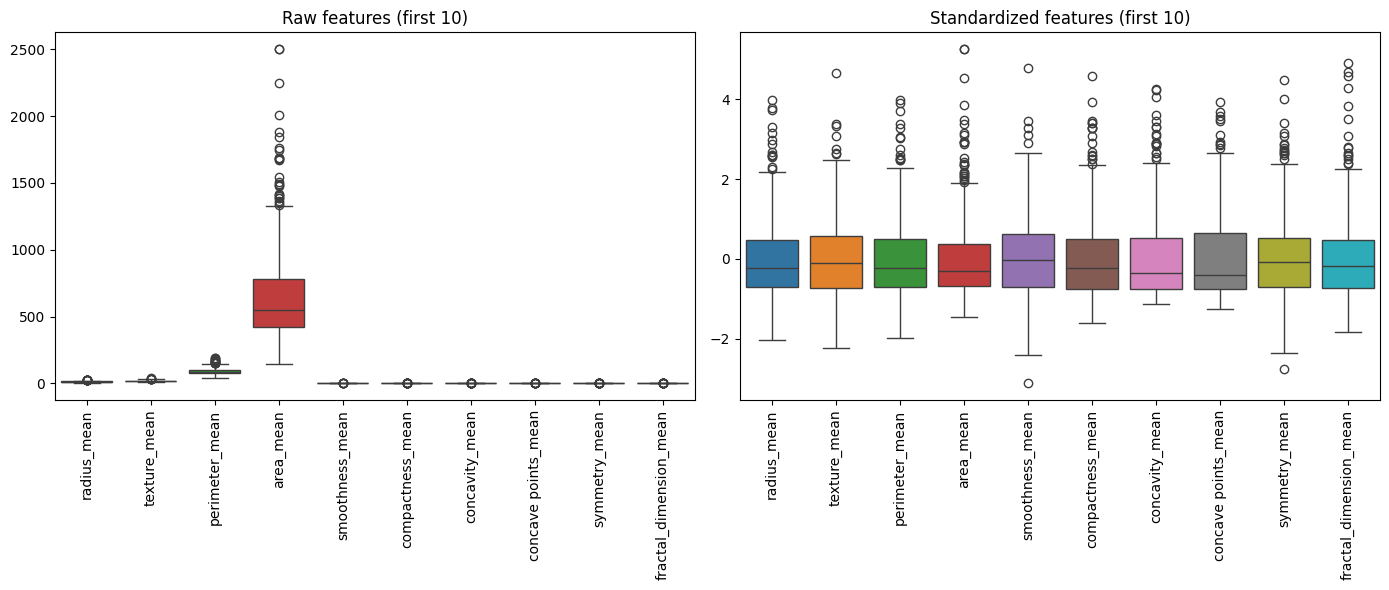

In [43]:
# Q1.2 Standardization

print(df.describe().T[['mean','std','min','max']])

# Separate features and target
X = df.drop(columns=["diagnosis"])   # numeric features only
y = df["diagnosis"]                  # target (M/B)

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Plot first 10 features before and after scaling
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(data=X.iloc[:, :10])
plt.title("Raw features (first 10)")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.boxplot(data=X_scaled.iloc[:, :10])
plt.title("Standardized features (first 10)")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Looking at the plots, we see that the features without standardization are wildly different in scale, while the features with standardization are much closer and more comparable. With standardization, we ensure that no single feature dominates due to its range, making standardized features more suitable, especially for algorithms that are sensitive to feature scaling.

## Q1.3 The importance of three way split with respect to hyperparameter search and robustness of any learned model

The three-way split is important for building robust machine learning models. The training set is used to learn model parameters, while the validation set is used to tune hyperparameters and select the best model configuration. Without a separate validation set, there is a risk of overfitting hyperparameters to the training data, leading to poor generalization. The test set is held out until the final evaluation to ensure that the model works on unseen data. This separation improves the robustness of the learned model and provides a more realistic estimate of its generalization ability.

# Q2 Decision Trees

## Q2.1 Training a Decision tree classifier using default parameters

In [44]:
# Q2.1 Training a decision tree classifier

clf = DecisionTreeClassifier(random_state=42)

# Cross validation on training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)

# Training the classifier
clf.fit(X_train, y_train)

# Evaluate on validation set
val_accuracy = clf.score(X_val, y_val)
print("Validation accuracy:", val_accuracy)

print("Mean and std of CV scores:", np.mean(cv_scores), np.std(cv_scores))

Cross-validation scores: [0.88405797 0.94117647 0.97058824 0.95588235 0.86764706]
Validation accuracy: 0.9385964912280702
Mean and std of CV scores: 0.9238704177323104 0.040627367474774134


The decision tree classifier was trained using default parameters. On the training set, the 5-fold cross validation produced accuracies corresponding to an average of 0.92 +- 0.04. When evaluated on the validation set, the classifier achieved an accuracy of 0.94. This result suggests that the decision tree already performs well with its defaultconfiguration, but it also shows deviation between training folds, indicating room for improvement.

## Q2.2 Feature importance and top 3 features from this model

In [45]:
# Q2.2 Feature importance and top 3 features from this model

# After fitting your decision tree:
importances = clf.feature_importances_

# Create a DataFrame for readability
feat_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_imp.head(5))

                 Feature  Importance
22       perimeter_worst    0.704881
27  concave points_worst    0.136016
21         texture_worst    0.038957
24      smoothness_worst    0.032706
19  fractal_dimension_se    0.028150


Feature importance is a measure of how well a feature reduces impurity across the whole tree. The three features that were most important is this tree classifier was perimeter_worst = 0.71, concave points_worst = 0.14 and texture_worst = 0.04. This shows that the model relies most on perimeter related measure of the tumor, followed by concavity and texture. 

## Q2.3 Varying the max_depth parameter to find the best depth

In [51]:
# Q2.3 Varying the max_depth parameter to find the best depth

depths = range(2, 11)   # depths 2 to 10
results = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
    results.append([d, np.mean(cv_scores), np.std(cv_scores)])

# Put results in a DataFrame for easy viewing
df_results = pd.DataFrame(results, columns=["Depth", "Mean Accuracy", "Std"])
print(df_results)

   Depth  Mean Accuracy       Std
0      2       0.929753  0.030895
1      3       0.935550  0.023647
2      4       0.932566  0.034266
3      5       0.929753  0.030895
4      6       0.929753  0.039498
5      7       0.923870  0.028027
6      8       0.923870  0.040627
7      9       0.923870  0.040627
8     10       0.923870  0.040627


I trained new decision trees with varying depths from 2 to 10, with the results shown in the table. The accuracy increased slightly between depths 2 and 3, peaking at 0.94 +- 0.02 for depth 3. Beyond depth 4, performance plateaued and showed higher variance with no gains in mean accuracy. This indicates that shallow trees underfit the data, while very deep trees risk overfotting. The optimal depth for this dataset is 3-4.